# Store Sales Forecasting 


## 1. Introduction
<a id="1"></a>

With the data set provided by [Kaggle](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview), we will analyze the key components of Time Series, which include seasonality, trends, stationarity, and cyclic behaviors. Also, by utilizing ensemble algorithmic learning, we will build hybrid models that can best extrapolate future values. The ultimate goal is to solidify time series concepts and practice machine learning techniques to adequately forecast and generate autoregressive models. 

## 2. Import the Data
<a id="2"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns   
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
import warnings
warnings.simplefilter("ignore")

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline

# Set up styles
mpl.style.use('ggplot')
mpl.rc("figure", autolayout=True, figsize=(11, 4))
sns.set(style='whitegrid')

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Set up parameters
plot_params = dict(
    color="0.7",
    style=".-",
    markeredgecolor="0.2",
    markerfacecolor="0.25",
    legend=False,
)

# Read holidays_events.csv
holidays_events = pd.read_csv('/Volumes/Programming/Store_Sales_Forecasting/Datasets/holidays_events.csv',
parse_dates = ['date'])

# Read train dataset as store_sales
store_sales = pd.read_csv('/Volumes/Programming/Store_Sales_Forecasting/Datasets/train.csv', 
parse_dates = ['date'], infer_datetime_format=True)


Check the Dataframe info

In [3]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [4]:
store_sales.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


As shown above, the stole_sales dataset consists of multiple records for each date differentiated by family variable. Thus, let us transform this data into a more workable dataset. Also, with the modified dataset, we can plot the sales variable to see the overview of sales respect to time.

In [5]:
store_sales = store_sales[['date', 'sales']]
store_sales_avg = store_sales.groupby('date').mean()
store_sales_avg.head(10)

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244
2013-01-06,291.636028
2013-01-07,188.621100
2013-01-08,178.646340
2013-01-09,169.770375


Now that we have organized the data into a daily scope, we can proceed to visualizing the sales.

Text(0, 0.5, 'Sales (daily mean)')

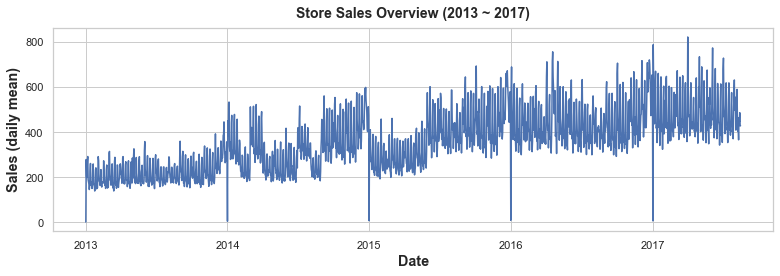

In [6]:
fig, axe = plt.subplots()
axe.plot('sales', data=store_sales_avg)
axe.set_title('Store Sales Overview (2013 ~ 2017)')
axe.set_xlabel('Date')
axe.set_ylabel('Sales (daily mean)')

From our visualization, we can observe some increasing trends, seasonal decline, and possible stationarity. However, these are merely assumptions. Throughout this notebook, we will delicately analyze the characteristics of the given time series to eventually use these insights for the forecasting.

## 3. Linear Regression & Serial Dependence Analysis
<a id="3"></a>

First, let us explore and analyze the data with linear regression.

In [7]:
# Set our target variable and store it into the df
df = store_sales_avg['sales'].to_frame()

# Create a dummy (time) variable 
df['time'] = np.arange(len(df))

X = df.loc[:, ['time']] # feature
y = df.loc[:, 'sales'] # target

# Model & Fit & Predict using the Linear Regression model
model = LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index = X.index)
y_pred.head()


date
2013-01-01    194.232790
2013-01-02    194.427137
2013-01-03    194.621484
2013-01-04    194.815831
2013-01-05    195.010178
dtype: float64

Now we have our predicted values for sales, we can plot them with the actual data to see the results.

Text(0, 0.5, 'Sales (daily mean)')

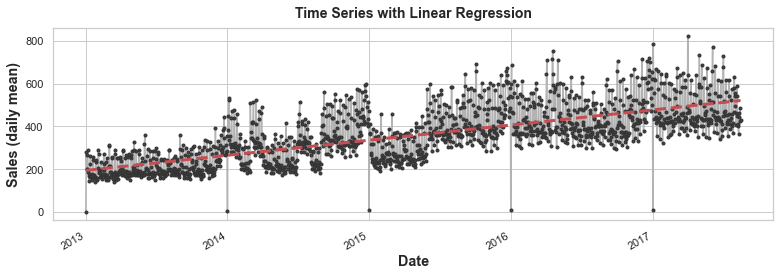

In [8]:
ax = y.plot(**plot_params)
ax = y_pred.plot(linestyle = '--', linewidth = 3, color='r')
ax.set_title("Time Series with Linear Regression")
ax.set_xlabel('Date')
ax.set_ylabel('Sales (daily mean)')

We explored our data utilizing the Linear Regression Modeling. Next, we can model serial dependence within out data. Serial Dependence demonstrate the dependency of the data on the past data. To observe such characteristic, we shall use lag functions for comparisons with the data from near past.

In [15]:
# Redefine df
df = store_sales_avg['sales'].to_frame()
df['lag_1'] = df['sales'].shift(1)

# To compare lag_1 with the actual data, create Linear Regression Model
X = df.loc[:,['lag_1']]
X.dropna(inplace=True)
y = df.loc[:,'sales']
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

Again, with the generated prediction values, we are then able to compare with the lagged sales values in the previous day.

Text(0.5, 1.0, 'Store Sales Serial Dependence')

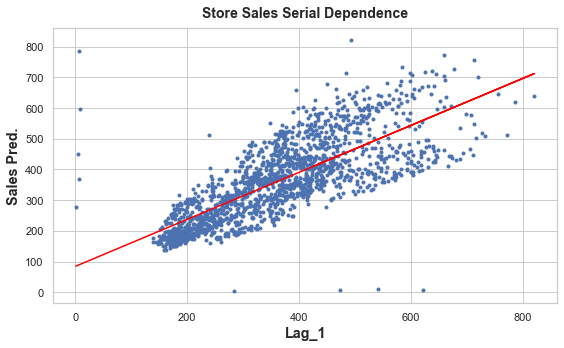

In [10]:
fig, axe = plt.subplots(figsize=(8,5))
axe.plot(X['lag_1'], y, '.')
axe.plot(X['lag_1'], y_pred, color = 'red')
axe.set_xlabel('Lag_1')
axe.set_ylabel('Sales Pred.')
axe.set_title('Store Sales Serial Dependence')

Since they have a linear relationship, we can assume that there exists serial dependency. However, we have only made use of 'Lag_1.' To achieve a comprehensive understanding of the serial dependency of the given data, we will be analyzing what happens as we keep increasing the depth of the lag. Before we do that, let's explore the key components of the time series: Trends, Seasonality, Stationarity, and Cyclic Behaviors.

## 4. Trends
<a id="4"></a>

Trend is a long term changes in the mean of the series. If the data have tendency to increase over time, we can say that it has an upward trend and so on. So to analyze the trend more effectively, we will use rolling() & mean() function to compute the trends. Then, we will visualize the computed trend with our actual data. 

Text(0, 0.5, 'Sales (daily mean)')

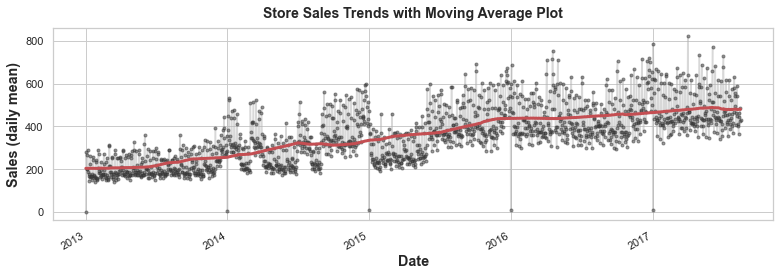

In [13]:
trend = store_sales_avg['sales'].rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = store_sales_avg['sales'].plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3, color='r')
ax.set_title("Store Sales Trends with Moving Average Plot")
ax.set_xlabel("Date")
ax.set_ylabel('Sales (daily mean)')

After the visualization, we can see that there exists some upward trends. However, can we back up that statement statistically? 

In order to solidify the upward trend in our data, it is necessary to perform some hypothesis testing. In this case, we will use WAVK test with the sieve-bootstrap enhancement.  

        - Since WAVK test assumes autocorrelation in the data, we need to prove this step first.

### Testing Autocorrelation

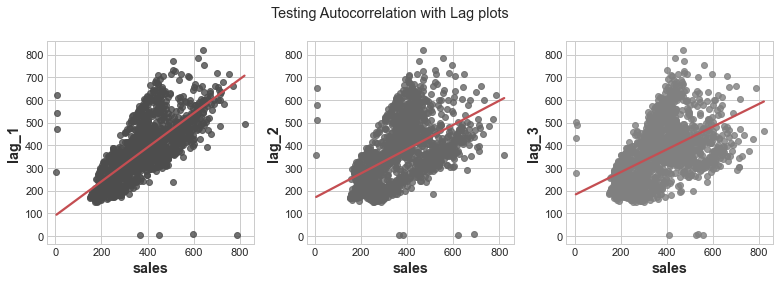

In [49]:
df['lag_2'] = df['sales'].shift(2)
df['lag_3'] = df['sales'].shift(3)

df.dropna(inplace=True)

fig, axe = plt.subplots(1,3)
fig.suptitle('Testing Autocorrelation with Lag plots')
axe[0] = sns.regplot(ax = axe[0], x='sales',y='lag_1', data=df, ci=None, scatter_kws=dict(color='0.3'), color='r')

axe[1] = sns.regplot(ax = axe[1], x='sales',y='lag_2', data=df, ci=None, scatter_kws=dict(color='0.4'), color='r')

axe[2] = sns.regplot(ax = axe[2], x='sales',y='lag_3', data=df, ci=None, scatter_kws=dict(color='0.5'), color='r')

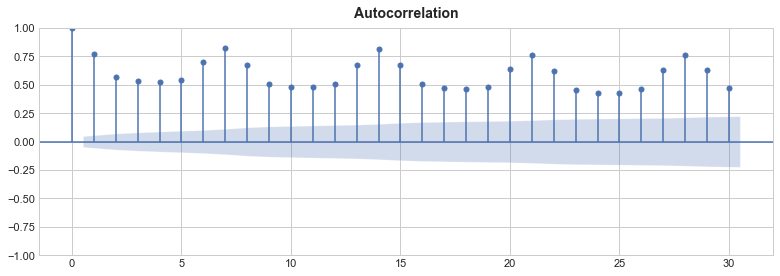

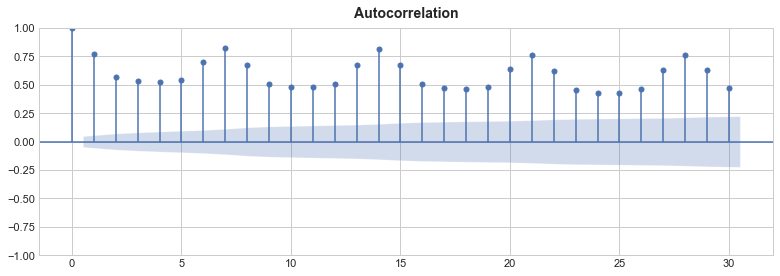

In [74]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(store_sales_avg['sales'], lags=30)
